# pydune

### A Python package for locating the dune toe on cross-shore beach profile transects.

### Table of Contents

This notebook demonstrates a few key elements of pydune, including:
1. [Creating a custom classifier](#1)
2. [Predicting dune toes](#2)
3. [Example plots and results](#3)

### Setup

Read the __*pydune*__ docs [here!](https://pydune-tomasbeuzen.readthedocs.io/en/latest/).

To run this notebook, pydune should be installed. I recommend creating a new virtual environment and then running:

`pip install pydune`

Depending on your setup, you may also need to install `jupyter` to run this notebook within the virtual environment, and if you want to generate plots in this notebook, you'll need `matplotlib`:

`pip install jupyter`

`pip install matplotlib`

### Imports

In [1]:
import os
import pickle
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydune.beach import Profile
from pydune.support import data_support as ds
from pydune.support import classifier_support as cs

### Load test data

In [2]:
# Load some test data of 200 profiles
with open('test_profiles.pkl', 'rb') as f:
    data = pickle.load(f)
x, z, toe = data['x'], data['z'], data['toe']

# 1. Creating a custom classifier <a name="1"></a>

In [3]:
# Create classifier
clf = cs.create_classifier(x, z, toe, window=40, min_buffer=40, max_buffer=200)

# Uncomment to save classifier to package directory
# import pydune
# path = os.path.dirname(pydune.__file__) + '/classifiers/'
# with open(path) as f:
#     joblib.dump(clf, f, protocol=pickle.HIGHEST_PROTOCOL)

# 2. Predicting dune toes <a name="2"></a>

In [4]:
# Instantiate Profile class
p = Profile(x, z)
# Make predictions of dune toe
toe_ml, prob_ml = p.predict_dunetoe_ml('barrier_island_clf', dune_crest='rr', window_size=101, threshold=0.97)
toe_mc = p.predict_dunetoe_mc(dune_crest='rr', window_size=101, threshold=0.97)
toe_rr = p.predict_dunetoe_rr(dune_crest='rr', window_size=101, threshold=0.97, toe_threshold=0.2, verbose=False)
toe_pd = p.predict_dunetoe_pd(dune_crest='rr', window_size=101, threshold=0.97)
# Predict dune crest
crest = p.predict_dunecrest()
# Predict shoreline
shoreline = p.predict_shoreline()

# 3. Example plots and results <a name="3"></a>

In [5]:
# Plotting Paramaters
params = {'legend.fontsize': 12,
           'axes.labelsize': 14,
           'axes.labelweight': 'bold',
           'axes.titlesize': 14,
           'axes.titleweight': 'bold',
           'xtick.labelsize': 14,
           'ytick.labelsize': 14,
           'mathtext.default':'regular'}
plt.rcParams.update(params)

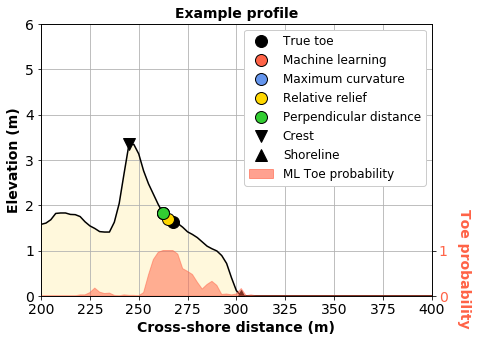

In [6]:
# Specify profile to plot
n = 0
# Figure metadata
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
toes = [toe[n], toe_ml[n], toe_mc[n], toe_rr[n], toe_pd[n]]
labels = ['True toe', 'Machine learning', 'Maximum curvature', 'Relative relief', 'Perpendicular distance']
colors = ['k', 'tomato', 'cornflowerblue', 'gold', 'limegreen']
# Generate figure
axes.plot(x, z[n], '-k')
axes.fill_between([70, 100], [0, 0], y2=-1, color='lightskyblue', alpha=0.5)
axes.fill_between(x, z[n], y2=-1, color='cornsilk', alpha=1)
axes.axvspan(-10, -9, color='tomato', alpha = 0.6, label='ML Toe probability') # legend placeholder
for i, itoe in enumerate(toes): 
    axes.plot(x[itoe], z[n, itoe],
              'o', color=colors[i], ms=12, mec='k', label=labels[i])
axes.plot(x[crest[n]], z[n, crest[n]], 'v', color='k', ms=12, mec='k', label='Crest')
axes.plot(x[shoreline[n]], z[n, shoreline[n]], '^', color='k', ms=12, mec='k', label='Shoreline')
axes.set_xlim(200, 400)
axes.set_ylim(0, 6)
axes.set_title('Example profile')
axes.set_xlabel('Cross-shore distance (m)')
axes.set_ylabel('Elevation (m)')
axes.grid()
axes.legend(framealpha=1)
# Plot dune toe ML probability
axes2 = axes.twinx() 
axes2.fill_between(x, prob_ml[n], color='tomato', alpha=0.5)
axes2.set_ylim(0, 6)
axes2.set_yticks([0, 1])
axes2.tick_params(axis='y', labelcolor='tomato')
axes2.yaxis.set_label_coords(1.1, 0.1)
axes2.set_ylabel('Toe probability', color='tomato', rotation=270);

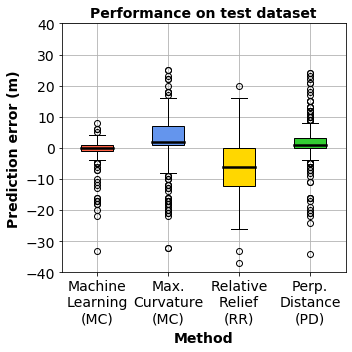

In [7]:
# Figure metadata
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
colors = ['tomato', 'cornflowerblue', 'gold', 'limegreen']
labels = ['Machine\nLearning\n(MC)', 'Max.\nCurvature\n(MC)', 'Relative\nRelief\n(RR)', 'Perp.\nDistance\n(PD)']
# Generate figure
data = (toe - np.vstack((toe_ml, toe_mc, toe_rr, toe_pd))).T.astype("float64")
# data1[:,2] *= 0.7
bplot = axes.boxplot(data,
                     labels=labels,
                     patch_artist=True,
                     medianprops = dict(linewidth=2.5, color='k'))
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
axes.set_ylabel('Prediction error (m)')
axes.set_xlabel('Method', labelpad=5)
axes.set_ylim(-40, 40)
axes.grid()
axes.set_title("Performance on test dataset")
plt.tight_layout()

In [8]:
df = pd.DataFrame({'MAE': [np.absolute(toe-toe_ml).mean(),
                           np.absolute(toe-toe_mc).mean(),
                           np.absolute(toe-toe_rr).mean(),
                           np.absolute(toe-toe_pd).mean()],
                   'RMSE': [np.sqrt(np.square(toe-toe_ml).mean()),
                            np.sqrt(np.square(toe-toe_mc).mean()),
                            np.sqrt(np.square(toe-toe_rr).mean()),
                            np.sqrt(np.square(toe-toe_pd).mean())],
                   'R2': [1 - (np.square(toe-toe_ml)).sum() / (np.square(toe-toe.mean())).sum(),
                          1 - (np.square(toe-toe_mc)).sum() / (np.square(toe-toe.mean())).sum(),
                          1 - (np.square(toe-toe_rr)).sum() / (np.square(toe-toe.mean())).sum(),
                          1 - (np.square(toe-toe_pd)).sum() / (np.square(toe-toe.mean())).sum()]},
                  index=['ML', 'MC', 'RR', 'PD']).round(2)
df

,MAE,RMSE,R2
ML,2.40,5.17,0.99
MC,7.59,10.57,0.96
RR,8.59,11.22,0.95
PD,5.18,8.22,0.98
